In [2]:
import os
# import drjit
gpu_num = 3 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
import pickle
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
# tf.config.run_functions_eagerly(True)

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In here, we generate additional results or data, which will e.g. be inserted into graphs from presentation.ipynb

## Time Domain Simulation

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      5.0 | 2.7041e-04 | 2.7387e-01 |       26582 |    98304000 |         8764 |       32000 |      2696.6 |reached max iter       
      6.0 | 1.3284e-04 | 1.4488e-01 |       13059 |    98304000 |         4636 |       32000 |      2728.6 |reached max iter       
      7.0 | 6.0465e-05 | 7.2375e-02 |        5944 |    98304000 |         2316 |       32000 |      2686.1 |reached max iter       
      8.0 | 3.7984e-05 | 3.6812e-02 |        3734 |    98304000 |         1178 |       32000 |      2679.2 |reached max iter       
      9.0 | 2.0498e-05 | 1.6031e-02 |        2015 |    98304000 |          513 |       32000 |      2689.7 |reached max iter       
     10.0 | 9.1756e-06 | 8.9375e-03 |         902 |    98304000 |          286 |     

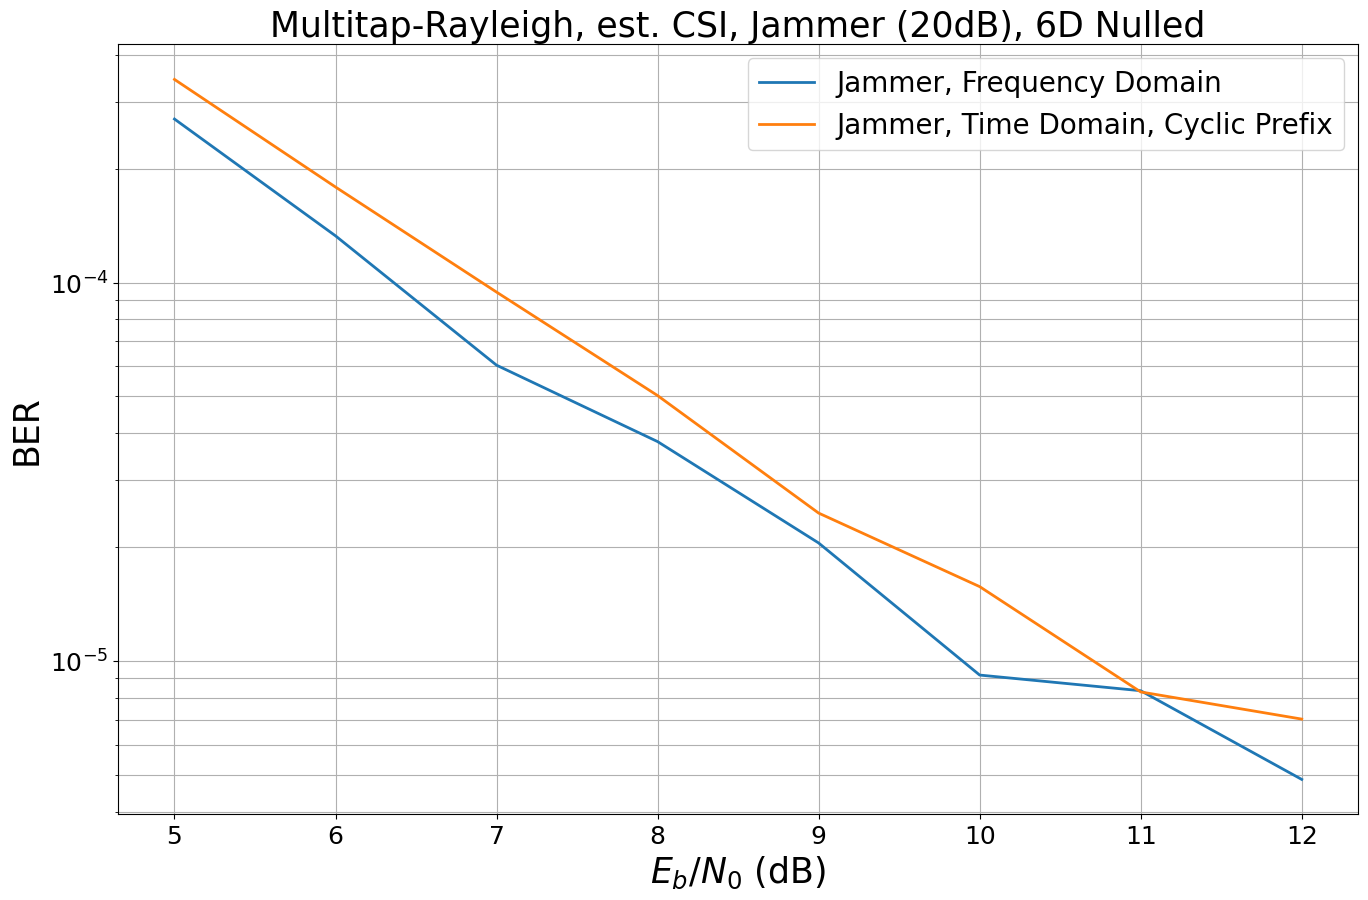

In [2]:
# 1. Multitap-Rayleigh, est. CSI
# 2. UMi, NR-Compliant (2.3us CP), est. CSI
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["num_ut"] = 6
model_parameters["perfect_csi"] = False
model_parameters["perfect_jammer_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 6
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(20.)
model_parameters["jammer_mitigation"] = "ian"
model_parameters["scenario"] = "umi"
model_parameters["cyclic_prefix_length"] = 50
# model_parameters["jammer_mitigation_dimensionality"] = 3
sim.BATCH_SIZE = 4
# sim.MAX_MC_ITER = 70
# sim.ebno_dbs = np.linspace(-5., 15., 10)
# sim.MAX_MC_ITER = 1500
# sim.ebno_dbs = np.linspace(-5., 15., 21)
sim.MAX_MC_ITER = 8000
sim.ebno_dbs = np.linspace(5., 12., 8)

model = Model(**model_parameters)
simulate_model(model, "Jammer, Frequency Domain")

model_parameters["domain"] = "time"
jammer_parameters["send_cyclic_prefix"] = True
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, Cyclic Prefix")

# jammer_parameters["send_cyclic_prefix"] = False
# model = Model(**model_parameters)
# simulate_model(model, "Jammer, Time Domain, No Cyclic Prefix")

ber_plots.title = "Multitap-Rayleigh, est. CSI, Jammer (20dB), 6D Nulled"
ber_plots()
with open("bers2/time_pos_rayleigh.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.0811e-04 | 2.6616e-01 |       20458 |    98304000 |         8517 |       32000 |       414.1 |reached max iter       
      1.0 | 9.7005e-05 | 1.3594e-01 |        9536 |    98304000 |         4350 |       32000 |       395.7 |reached max iter       
      2.0 | 5.3416e-05 | 6.8031e-02 |        5251 |    98304000 |         2177 |       32000 |       395.3 |reached max iter       
      3.0 | 2.2349e-05 | 3.0500e-02 |        2197 |    98304000 |          976 |       32000 |       396.6 |reached max iter       
      4.0 | 1.2644e-05 | 1.5969e-02 |        1243 |    98304000 |          511 |       32000 |       398.6 |reached max iter       
      5.0 | 6.4799e-06 | 6.3438e-03 |         637 |    98304000 |          203 |     

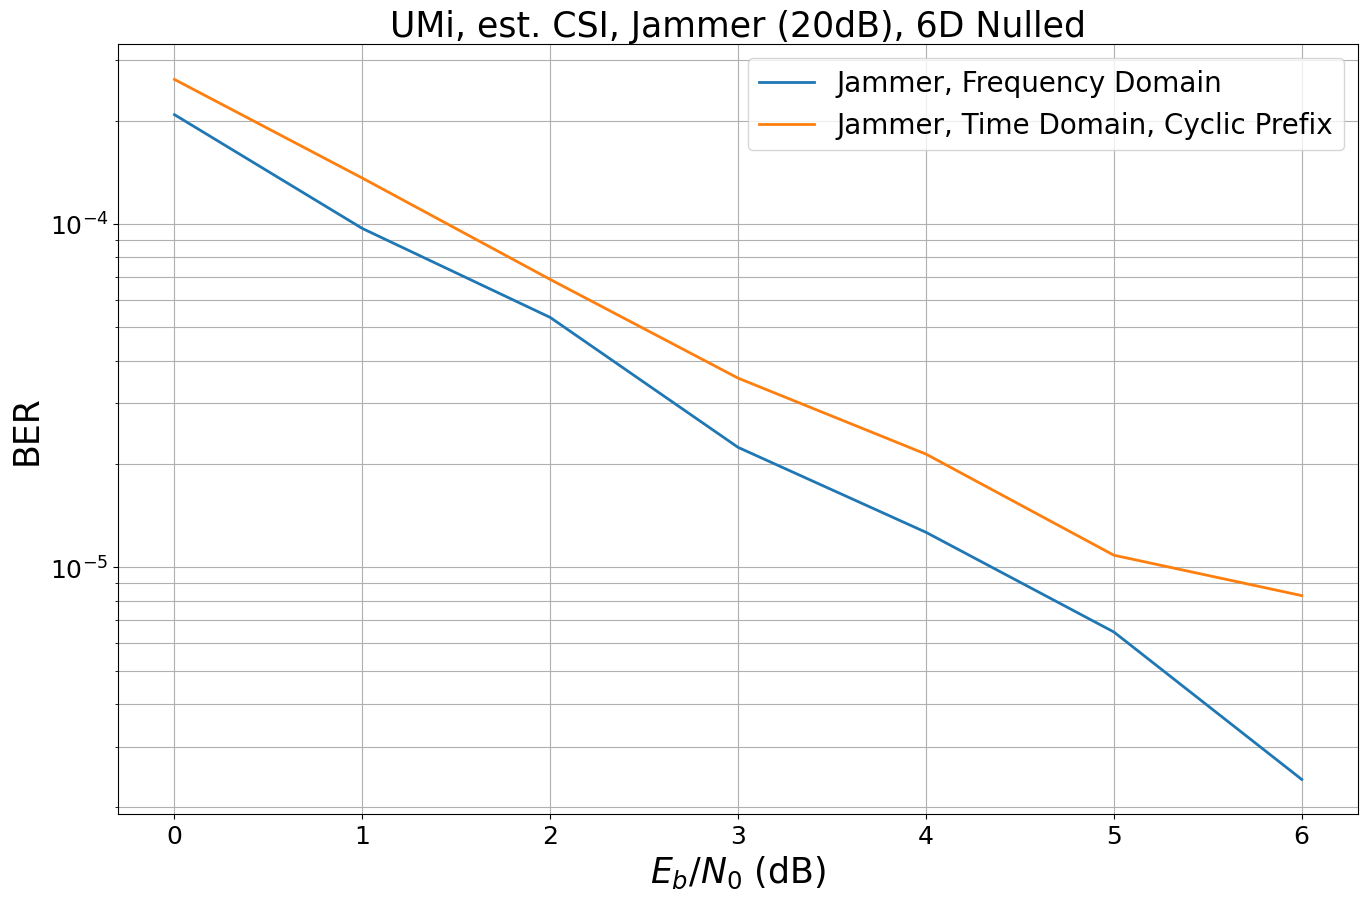

In [2]:
# 1. Multitap-Rayleigh, est. CSI
# 2. UMi, NR-Compliant (2.3us CP), est. CSI
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["num_ut"] = 6
model_parameters["perfect_csi"] = True
model_parameters["perfect_jammer_csi"] = True
model_parameters["num_silent_pilot_symbols"] = 6
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(20.)
model_parameters["jammer_mitigation"] = "ian"
model_parameters["scenario"] = "umi"
model_parameters["cyclic_prefix_length"] = 100
# model_parameters["jammer_mitigation_dimensionality"] = 3
sim.BATCH_SIZE = 4
# sim.MAX_MC_ITER = 70
# sim.ebno_dbs = np.linspace(-5., 15., 10)
# sim.MAX_MC_ITER = 1500
# sim.ebno_dbs = np.linspace(-5., 15., 21)
sim.MAX_MC_ITER = 8000
sim.ebno_dbs = np.linspace(0., 6., 7)

model = Model(**model_parameters)
simulate_model(model, "Jammer, Frequency Domain")

model_parameters["domain"] = "time"
jammer_parameters["send_cyclic_prefix"] = True
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, Cyclic Prefix")

# jammer_parameters["send_cyclic_prefix"] = False
# model = Model(**model_parameters)
# simulate_model(model, "Jammer, Time Domain, No Cyclic Prefix")

ber_plots.title = "UMi, est. CSI, Jammer (20dB), 6D Nulled"
ber_plots()
with open("bers/time_pos_umi.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

#### Jammer Singular Values

## Coded Jammer Training

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 6.7706e-02 | 9.8263e-01 |    53246458 |   786432000 |       251553 |      256000 |       613.1 |reached max iter       
     -4.0 | 4.2665e-02 | 8.9649e-01 |    33552898 |   786432000 |       229501 |      256000 |       603.4 |reached max iter       
     -3.0 | 2.8828e-02 | 7.6566e-01 |    22670940 |   786432000 |       196008 |      256000 |       604.1 |reached max iter       
     -2.0 | 2.0968e-02 | 6.6041e-01 |    16489696 |   786432000 |       169065 |      256000 |       602.6 |reached max iter       
     -1.0 | 1.6221e-02 | 6.3572e-01 |    12756462 |   786432000 |       162744 |      256000 |       604.5 |reached max iter       
      0.0 | 1.3247e-02 | 7.1436e-01 |    10418094 |   786432000 |       182876 |     

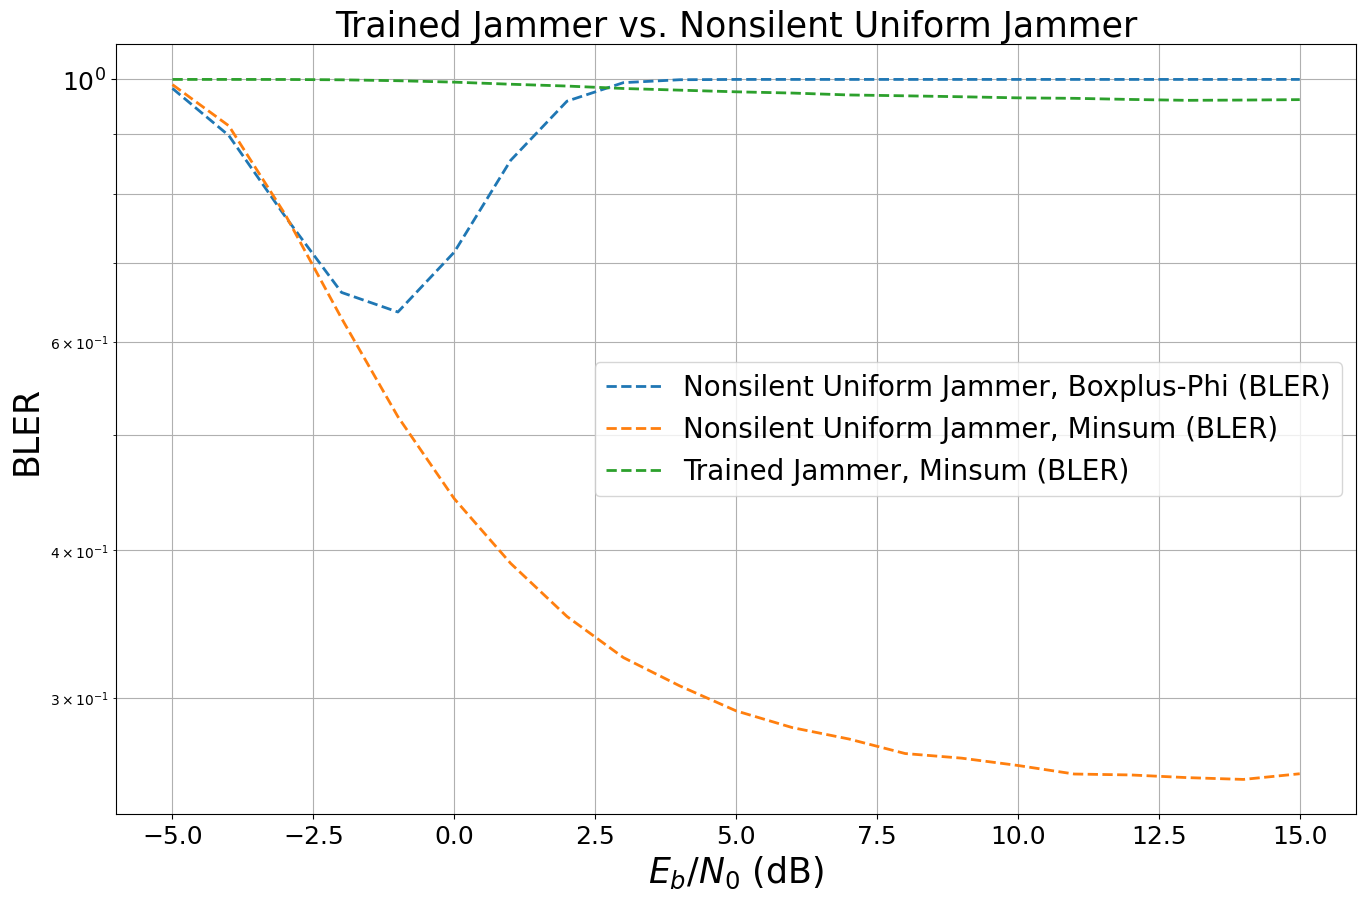

In [5]:
# noch einen Plot mit Minsum
ber_plots.reset()
# common parameters
model_parameters = {}
jammer_parameters = {}
decoder_parameters={}
model_parameters["perfect_csi"] = False
model_parameters["num_ut"] = 4
model_parameters["jammer_present"] = True
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
model_parameters["num_silent_pilot_symbols"] = 4
model_parameters["coderate"] = 0.5
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
decoder_parameters["num_iter"] = 8
decoder_parameters["cn_type"] = "boxplus-phi"
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["decoder_parameters"] = decoder_parameters
sim.BATCH_SIZE = 128
# sim.MAX_MC_ITER = 50
# sim.ebno_dbs = np.linspace(-5., 15., 10)
sim.MAX_MC_ITER = 2000
sim.ebno_dbs = np.linspace(-5., 15., 21)

jammer_power = 1.0
model_parameters["jammer_power"] = jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([10,1])], axis=0))

# Nonsilent Uniform jammer
model = Model(**model_parameters)
model._decoder.llr_max = 1000
simulate_model(model, "Nonsilent Uniform Jammer, Boxplus-Phi", add_bler=True)

# Nonsilent Uniform jammer with Minsum
decoder_parameters["cn_type"] = "minsum"
model = Model(**model_parameters)
model._decoder.llr_max = 1000
simulate_model(model, "Nonsilent Uniform Jammer, Minsum", add_bler=True)

# Trained jammer
model_parameters["jammer_power"] = jammer_power
model = Model(**model_parameters)
model._decoder.llr_max = 1000
load_weights(model, "weights/coded/symbol/iteration_loss_2/ue_4_alpha_0.5_exp_False_8_iter.pickle")
simulate_model(model, "Trained Jammer, Minsum", add_bler=True)

ber_plots.title = "Trained Jammer vs. Nonsilent Uniform Jammer"
ber_plots(show_ber=False)
with open("bers/coded_bler.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

## 

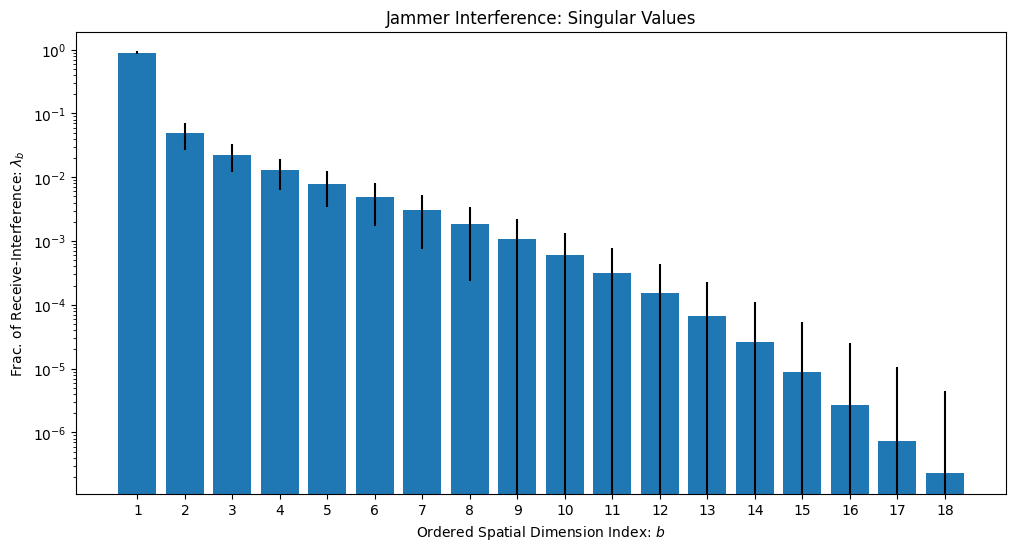

In [21]:
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["domain"] = "time"
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(50.)
model_parameters["jammer_mitigation"] = "pos"
model_parameters["num_silent_pilot_symbols"] = 50
model_parameters["num_ofdm_symbols"] = 53
model_parameters["return_jammer_signals"] = True
model_parameters["num_ut"] = 1
model_parameters["num_ut_ant"] = 1
jammer_parameters["num_tx"] = 1
jammer_parameters["num_tx_ant"] = 1
#NR compliant
model_parameters["carrier_frequency"] = 3.5e9
model_parameters["fft_size"] = 667 # * 30kHz = 20MHz
model_parameters["cyclic_prefix_length"] = 47 # 667 * 144 / 2048
model_parameters["subcarrier_spacing"] = 30e3

ebno_db = 100.0
BATCH_SIZE = 1
name = "Multiple Jammers"

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

rel_svs = []
model = Model(**model_parameters)
# for i in range(10):
for i in range(10000):
    if i % 100 == 0:
        print(i, end='\r')
    b, llr, jammer_signals = model(BATCH_SIZE, ebno_db)
    rel_svs.append(relative_singular_values(jammer_signals))
rel_svs = tf.stack(rel_svs)
mean = tf.reduce_mean(rel_svs, axis=0)
std = tf.math.reduce_std(rel_svs, axis=0)

#log scale
ax.set_yscale("log")

x_labels = np.arange(len(mean), dtype=np.int32) + 1
ax.bar(x_labels, mean, yerr=std)
ax.set_xticks(x_labels)
ax.set_ylabel(r"Frac. of Receive-Interference: $\lambda_b$")
ax.set_xlabel(r"Ordered Spatial Dimension Index: $b$")
ax.set_title("Jammer Interference: Singular Values")

plt.show()